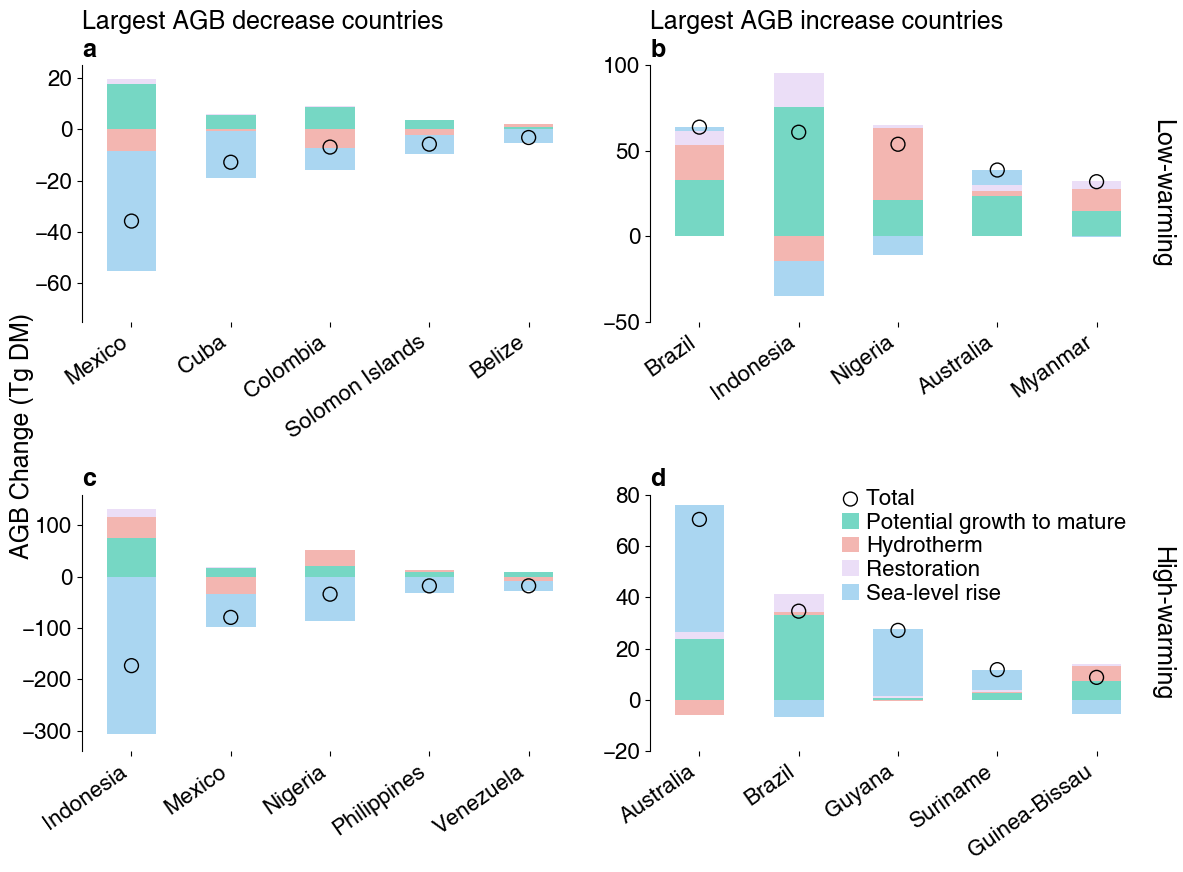

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# Load data
with open('../data/DIVA_data/Coast_with_Mang.pkl', 'rb') as f:
    data = pickle.load(f)

# Extract relevant data
area_after_SLR_126 = data['area_after_SLR_126'][:, 1]
area_after_SLR_585 = data['area_after_SLR_585'][:, 1]
area_restoration_126 = data['area_restoration_126'][:, 0]
area_restoration_585 = data['area_restoration_585'][:, 0]
agb_present = data['agb_present']
area = data['area']
agb_grow = data['agb_grow']
agb_126 = data['agb_126']
agb_585 = data['agb_585']

# Load ID_Country
DIVA_coastline = pd.read_csv("../data/DIVA_data/DIVA_coastline_WGS84_with_Mang.csv")
ID_Country = DIVA_coastline["ID_Country"].str.split(" ", n=1, expand=True)
ID_Country.columns = ["ClsFID", "Country"]
ID_Country["ClsFID"] = ID_Country["ClsFID"].astype(float)
ID_Country = ID_Country.sort_values(by="ClsFID").reset_index(drop=True)

countries = ID_Country['Country'].unique()
l = len(countries)

# Function to calculate AGB changes
def calculate_agb_changes(agb, area_after_SLR, area_restoration):
    agb_change = (agb * (area_after_SLR + area_restoration) - agb_present * area) / 10**6
    agb_change_grow = (agb_grow * area - agb_present * area) / 10**6
    agb_change_HT = (agb * area - agb_grow * area) / 10**6
    agb_change_RES = (agb * area_restoration) / 10**6
    agb_change_SLR = (agb * (area_after_SLR - area)) / 10**6
    area_change_SLR = area_after_SLR - area
    return agb_change, agb_change_grow, agb_change_HT, agb_change_RES, agb_change_SLR, area_change_SLR

# Calculate AGB changes for 126 and 585 scenarios
agb_changes_126 = calculate_agb_changes(agb_126, area_after_SLR_126, area_restoration_126)
agb_changes_585 = calculate_agb_changes(agb_585, area_after_SLR_585, area_restoration_585)

# Function to aggregate AGB changes by country
def aggregate_agb_changes_by_country(agb_changes):
    agb_change_country = np.zeros(l)
    agb_change_grow_country = np.zeros(l)
    agb_change_HT_country = np.zeros(l)
    agb_change_RES_country = np.zeros(l)
    agb_change_SLR_country = np.zeros(l)
    
    for i, country in enumerate(countries):
        idx = ID_Country[ID_Country['Country'] == country].index
        valid_idx = idx[~np.isnan(agb_changes[0][idx])]
        if not valid_idx.empty:
            agb_change_country[i] = np.nansum(agb_changes[0][idx])
            agb_change_grow_country[i] = np.nansum(agb_changes[1][idx])
            agb_change_HT_country[i] = np.nansum(agb_changes[2][idx])
            agb_change_RES_country[i] = np.nansum(agb_changes[3][idx])
            agb_change_SLR_country[i] = np.nansum(agb_changes[4][idx])
    
    return pd.DataFrame({
        'Country': countries,
        'AGB_Change': agb_change_country,
        'AGB_Change_Grow': agb_change_grow_country,
        'AGB_Change_HT': agb_change_HT_country,
        'AGB_Change_RES': agb_change_RES_country,
        'AGB_Change_SLR': agb_change_SLR_country
    }).sort_values(by='AGB_Change')

# Aggregate AGB changes by country for 126 and 585 scenarios
country_agb_change_126 = aggregate_agb_changes_by_country(agb_changes_126)
country_agb_change_585 = aggregate_agb_changes_by_country(agb_changes_585)


# Plot AGB changes by country
data1 = country_agb_change_126.iloc[:5]
data2 = country_agb_change_126.iloc[-5:].iloc[::-1]
data3 = country_agb_change_585.iloc[:5]
data4 = country_agb_change_585.iloc[-5:].iloc[::-1]

# Set global font to Helvetica
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 16
# Set the mathtext font to Helvetica
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Helvetica'
plt.rcParams['mathtext.it'] = 'Helvetica:italic'
plt.rcParams['mathtext.bf'] = 'Helvetica:bold'


fig, axs = plt.subplots(2, 2, figsize=(12, 9))
fig.text(0.01, 0.5, 'AGB Change (Tg DM)', va='center', rotation='vertical', fontsize=18)

ax1 = axs[0, 0]
AGB_change = data1[['AGB_Change_Grow', 'AGB_Change_HT', 'AGB_Change_RES', 'AGB_Change_SLR']]
AGB_change.plot(kind='bar', stacked=True, ax=ax1, color=['#76d7c4', '#f3b6b1', '#ebdef7', '#aad6f1'])
ax1.scatter(range(0, 5), data1.iloc[:, 1], facecolor='none', edgecolor='black', s=100, label='Total')

ax1.set_xticklabels(data1['Country'], rotation=35, ha='right')
ax1.set_ylim([-75, 25])
ax1.legend().set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_title(f"Largest AGB decrease countries\n$\mathbf{{{chr(97)}}}$", loc='left', fontsize=18)

ax2 = axs[0, 1]
AGB_change = data2[['AGB_Change_Grow', 'AGB_Change_HT', 'AGB_Change_RES', 'AGB_Change_SLR']]
AGB_change.plot(kind='bar', stacked=True, ax=ax2, color=['#76d7c4', '#f3b6b1', '#ebdef7', '#aad6f1'])
ax2.scatter(range(0, 5), data2.iloc[:, 1], facecolor='none', edgecolor='black', s=100, label='Total')

ax2.set_xticklabels(data2['Country'], rotation=35, ha='right')
ax2.set_ylim([-50, 100])
ax2.legend().set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.set_title(f"Largest AGB increase countries\n$\mathbf{{{chr(98)}}}$", loc='left', fontsize=18)

ax2_right = ax2.twinx()
ax2_right.set_ylabel('Low-warming', rotation=270, color='k', labelpad=20, fontsize=18)
ax2_right.set_yticks([])
ax2_right.spines['right'].set_visible(False)
ax2_right.spines['top'].set_visible(False)
ax2_right.spines['left'].set_visible(False)
ax2_right.spines['bottom'].set_visible(False)

ax3 = axs[1, 0]
AGB_change = data3[['AGB_Change_Grow', 'AGB_Change_HT', 'AGB_Change_RES', 'AGB_Change_SLR']]
AGB_change.plot(kind='bar', stacked=True, ax=ax3, color=['#76d7c4', '#f3b6b1', '#ebdef7', '#aad6f1'])
ax3.scatter(range(0, 5), data3.iloc[:, 1], facecolor='none', edgecolor='black', s=100, label='Total')

ax3.set_xticklabels(data3['Country'], rotation=35, ha='right')
ax3.set_ylim([-340, 160])
ax3.legend().set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.set_title(f"$\mathbf{{{chr(99)}}}$", loc='left', fontsize=18)

ax4 = axs[1, 1]
AGB_change = data4[['AGB_Change_Grow', 'AGB_Change_HT', 'AGB_Change_RES', 'AGB_Change_SLR']]
AGB_change.plot(kind='bar', stacked=True, ax=ax4, color=['#76d7c4', '#f3b6b1', '#ebdef7', '#aad6f1'])
ax4.scatter(range(0, 5), data4.iloc[:, 1], facecolor='none', edgecolor='black', s=100, label='Total')

ax4.set_xticklabels(data4['Country'], rotation=35, ha='right')
ax4.set_ylim([-20, 80])
handles, _ = ax1.get_legend_handles_labels()
labels = ['Total', 'Potential growth to mature', 'Hydrotherm', 'Restoration', 'Sea-level rise']
ax4.legend(handles, labels, loc='upper right', frameon=False, labelspacing=0.12, bbox_to_anchor=(1, 1.1), handlelength=0.8, handletextpad=0.3)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.set_title(f"$\mathbf{{{chr(100)}}}$", loc='left', fontsize=18)

ax4_right = ax4.twinx()
ax4_right.set_ylabel('High-warming', rotation=270, color='k', labelpad=20, fontsize=18)
ax4_right.set_yticks([])
ax4_right.spines['right'].set_visible(False)
ax4_right.spines['top'].set_visible(False)
ax4_right.spines['left'].set_visible(False)
ax4_right.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.savefig('../fig/py04_country_change.jpg', dpi=300)